<a href="https://colab.research.google.com/github/dercodeKoenig/dqn_trading_gcloudvm/blob/main/evaluate_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.12-py3-none-any.whl size=102969 sha256=db81e8df4a2f629acb828100c30ef71f68cf0288488b5670deeaa4019344aeb1
  Stored in directory: /root/.cache/pip/wheels/1e/0b/7c/50f8e89c3d2f82838dbd7afeddffbb9357003009ada98216c7
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
%%writefile kaggle.json
{"username":"bpwqsdd","key":"c01be61298c740525cfe76bfcbe1d233"}

Writing kaggle.json


In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
##################
!pwd
!kaggle datasets download -d bpwqsdd/dqn-t0-output
!unzip dqn-t0-output.zip
#!kaggle datasets download -d thetensortoffel/dqn-t0-output-2
#!unzip dqn-t0-output-2.zip
#!kaggle datasets download -d innercirclecat/dqn-t0-output-3
#!unzip dqn-t0-output-3.zip

/content
Dataset URL: https://www.kaggle.com/datasets/bpwqsdd/dqn-t0-output
License(s): unknown
 97% 170M/175M [00:06<00:00, 29.5MB/s]
100% 175M/175M [00:06<00:00, 28.2MB/s]
Archive:  dqn-t0-output.zip
  inflating: dqn_trading_gcloudvm/.git/FETCH_HEAD  
  inflating: dqn_trading_gcloudvm/.git/HEAD  
  inflating: dqn_trading_gcloudvm/.git/ORIG_HEAD  
  inflating: dqn_trading_gcloudvm/.git/config  
  inflating: dqn_trading_gcloudvm/.git/description  
  inflating: dqn_trading_gcloudvm/.git/hooks/applypatch-msg.sample  
  inflating: dqn_trading_gcloudvm/.git/hooks/commit-msg.sample  
  inflating: dqn_trading_gcloudvm/.git/hooks/fsmonitor-watchman.sample  
  inflating: dqn_trading_gcloudvm/.git/hooks/post-update.sample  
  inflating: dqn_trading_gcloudvm/.git/hooks/pre-applypatch.sample  
  inflating: dqn_trading_gcloudvm/.git/hooks/pre-commit.sample  
  inflating: dqn_trading_gcloudvm/.git/hooks/pre-merge-commit.sample  
  inflating: dqn_trading_gcloudvm/.git/hooks/pre-push.sample  
  infla

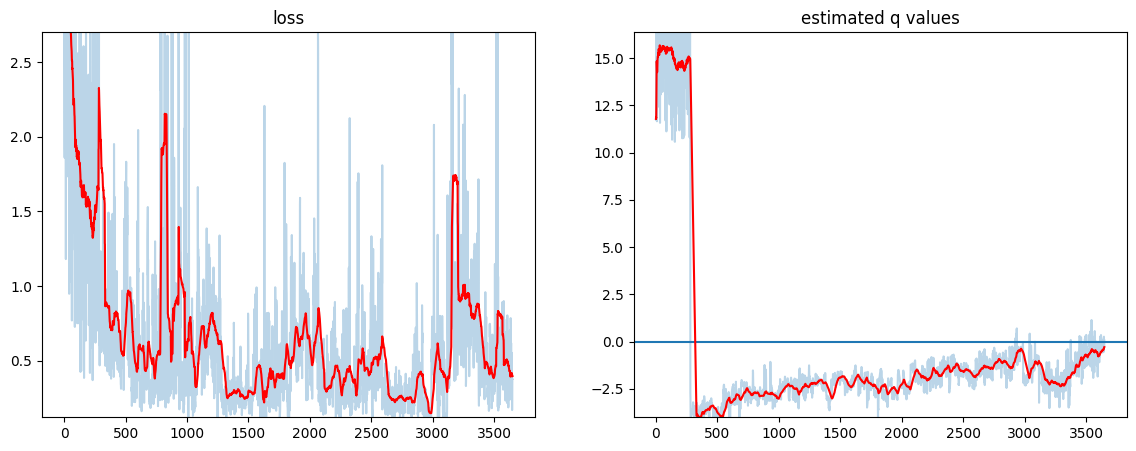

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def get_values(fn):
    f = open(fn)
    lines = f.readlines()
    f.close()

    lines = [float(x.replace("\n","")) for x in lines]
    for i in range(len(lines)):
        if np.isnan(lines[i]):
            lines[i] = 0

    return lines

avg_n=50
k=2

def plot_logs(losses, qs, name):
    fig, ax = plt.subplots(1,2,figsize=(14,5))
    ax[0].set_title("loss")
    lower, upper = np.percentile(losses, [k, 100-k])
    ax[0].set_ylim(lower, upper)
    ax[0].plot(losses, alpha=0.3)
    ax[0].plot([np.mean(losses[max(0,i-avg_n):i+1]) for i in range(len(losses))], c="r")
    ax[1].set_title("estimated q values")
    lower, upper = np.percentile(qs, [k, 100-k])
    ax[1].set_ylim(lower, upper)
    ax[1].plot(qs, alpha=0.3)
    ax[1].axhline(0)
    ax[1].plot([np.mean(qs[max(0,i-avg_n):i+1]) for i in range(len(qs))], c="r")
    plt.savefig(name)

try:
	losses = get_values("dqn_trading_gcloudvm/t0/loss.txt")
	qs = get_values("dqn_trading_gcloudvm/t0/qv.txt")
	plot_logs(losses, qs, "t0.jpg")
except:pass

In [ ]:
!kaggle datasets download -d bpwqsdd/us-index-cfd-data
!mkdir data
!unzip us-index-cfd-data.zip
!mv *.o data/

Dataset URL: https://www.kaggle.com/datasets/bpwqsdd/us-index-cfd-data
License(s): CC0-1.0
100% 1.16G/1.16G [00:40<00:00, 34.7MB/s]
100% 1.16G/1.16G [00:40<00:00, 30.3MB/s]
Archive:  us-index-cfd-data.zip
  inflating: .ipynb_checkpoints/info-checkpoint.txt  
  inflating: ENQ_1.csv               
  inflating: ENQ_1.o                 
  inflating: ENQ_1_inverted.o        
  inflating: EP_1.csv                
  inflating: EP_1.o                  
  inflating: EP_1_inverted.o         
  inflating: US30_1.csv              
  inflating: US30_1.o                
  inflating: US30_1_inverted.o       
  inflating: US500_1.csv             
  inflating: US500_1.o               
  inflating: US500_1_inverted.o      
  inflating: USTEC_1.csv             
  inflating: USTEC_1.o               
  inflating: USTEC_1_inverted.o      
  inflating: YM_1.csv                
  inflating: YM_1.o                  
  inflating: YM_1_inverted.o         
  inflating: info.txt                
  inflating: parts_

In [ ]:
!cp dqn_trading_gcloudvm/t0/dqn_weights.h5 .
!cp dqn_trading_gcloudvm/t0/manager.py .
!cp dqn_trading_gcloudvm/t0/make_model.py .
!cp dqn_trading_gcloudvm/t0/utils.py .

In [ ]:
from manager import *
from utils import *
from make_model import *

import tensorflow as tf
import time
from manager import candle_class
import random
import numpy as np
from collections import deque
import time
import os

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [ ]:
path2 = "parts_EP_1_inverted.o/"
path1 = "parts_ENQ_1_inverted.o/"
cm = 2.5

In [ ]:

class match_time_cor_market:
    def __init__ (self,path):
        self.path = path
        self.candle_index = 0
        self.subfile_index = -1
        self.subfiles = sorted([x for x in os.listdir(path) if "part" in x])
        self.candles = []
        self.last_candle = candle_class(0,0,0,0,[1,1,2000,0,0,0])
        self.time_int2 = 0

    def get_next_candle(self):
        if self.candle_index >= len(self.candles):
            self.candle_index = 0
            self.subfile_index+=1
            if self.subfile_index == len(self.subfiles):
                print("error - no more subfiles")
                return -1

            print("second market load", self.path + self.subfiles[self.subfile_index])
            self.candles = Load(self.path + self.subfiles[self.subfile_index])

        self.last_candle = self.candles[self.candle_index]
        self.candle_index+=1
        return 0


    def get_candle_by_time_match(self, t):
        t = t.split(":")
        t = [int(x) for x in t]
        time_int1 = (t[0] + t[1]*31+t[2]*366) * 24 * 60 + t[3]*60 + t[4]



        while self.time_int2 < time_int1:
            if self.get_next_candle() == 0:
                t = self.last_candle.t
                t = t.split(":")
                t = [int(x) for x in t]
                self.time_int2 = (t[0] + t[1]*31+t[2]*366) * 24 * 60 + t[3]*60 + t[4]
            else:
                return -1

        #print(time_int1, self.time_int2)

        if self.time_int2 == time_int1:
            return self.last_candle
        if self.time_int2 > time_int1:
            #print("candle data missing - skip candle")
            return self.last_candle


In [ ]:
data_dir = "data/"
path1 = data_dir+path1
path2 = data_dir+path2
name1 = path1.split("/")[-2]
print("path1:", path1)
name2 = path2.split("/")[-2]
print("path:", path2)
print("cm:", cm)

subfiles = sorted([x for x in os.listdir(path1) if "part" in x])


start_ofs = 50000

start = 6500000


print("start at", name1, "-", start)


path1: data/parts_ENQ_1_inverted.o/
path: data/parts_EP_1_inverted.o/
cm: 2.5
start at parts_ENQ_1_inverted.o - 6500000


In [ ]:
model = make_model()
model.load_weights("dqn_weights.h5")

In [ ]:

candle_counter = -1
last_state = 0

x = manager()
x2 = manager()

c_match_system = match_time_cor_market(path2)

position = 0
balance = 0
equity_list = []
balances = []
vol = 1

outputs = []
candle_position_history = []

entry_price = -1
reset_entry_price = False


def close(c):
    global balance, position, entry_price
    balance += (c - entry_price) * vol * position
    balance -= cm / 2 * vol
    position = 0
    entry_price = -1


done = False
sample_counter = 0
for part in subfiles:
    if candle_counter + 100000 < start:
        candle_counter+=100000
        continue
    candles = Load(path1+part)
    for i in range(0, len(candles)):
                candle_counter+=1

                candle2 = c_match_system.get_candle_by_time_match(candles[i].t)
                if candle2 == -1:
                    print("secondary data file ended - break")
                    break

                ret2 = x2.push_m1_candle(candle2)
                ret = x.push_m1_candle(candles[i])

                if candle_counter>=start+start_ofs:

                    #disable relative scaling
                    #ret[0][1] = 1
                    #########

                    inp = get_inputs_from_ret(ret, x)
                    inp2 = get_inputs_from_ret(ret2, x2)
                    inp2 = [inp2[0]] + [inp2[3]] + [inp2[4]] + [inp2[5]]

                    new_state = [0]+inp+inp2


                    m_input = [np.expand_dims(new_state[i], axis=0) for i in range(len(new_state))]
                    o = model(m_input) # scores: short, long, neutral
                    o = o.numpy().tolist()[0]
                    o[2] = -999
                    action = np.argmax(o)


                    if reset_entry_price:
                        entry_price = x.m1_candles[-1].o
                        reset_entry_price = False

                    candle_position_history.append([x.m1_candles[-1], position])




                    c = x.m1_candles[-1].c
                    open_profit = position * vol * (c - entry_price)

                    if action == 0: # short
                        if position != -1:
                            close(c)
                            position = -1
                            balance -= cm / 2 * vol
                            reset_entry_price = True

                    if action == 1: # long
                        if position != 1:
                            close(c)
                            position = 1
                            balance -= cm / 2 * vol
                            reset_entry_price = True

                    if action == 2: # neutral
                        if position != 0:
                            close(c)

                    balances.append(balance)


                    equity = balance + open_profit
                    equity_list.append(equity)

                    #print([ round(i,2) for i in  o.numpy().flatten().tolist() ], position, balance, equity)
                    sample_counter+=1
                    if sample_counter % 100 == 0:
                        print(sample_counter, position, equity)

                    outputs.append(o)

                    if sample_counter >= 23*60*5*4:
                        done = True
                        break
    if done:
            print("done")
            break

loading data/parts_ENQ_1_inverted.o/part_065
second market load data/parts_EP_1_inverted.o/part_000
loading data/parts_EP_1_inverted.o/part_000
second market load data/parts_EP_1_inverted.o/part_001
loading data/parts_EP_1_inverted.o/part_001
second market load data/parts_EP_1_inverted.o/part_002
loading data/parts_EP_1_inverted.o/part_002
second market load data/parts_EP_1_inverted.o/part_003
loading data/parts_EP_1_inverted.o/part_003
second market load data/parts_EP_1_inverted.o/part_004
loading data/parts_EP_1_inverted.o/part_004
second market load data/parts_EP_1_inverted.o/part_005
loading data/parts_EP_1_inverted.o/part_005
second market load data/parts_EP_1_inverted.o/part_006
loading data/parts_EP_1_inverted.o/part_006
second market load data/parts_EP_1_inverted.o/part_007
loading data/parts_EP_1_inverted.o/part_007
second market load data/parts_EP_1_inverted.o/part_008
loading data/parts_EP_1_inverted.o/part_008
second market load data/parts_EP_1_inverted.o/part_009
loading d

In [ ]:
#new_state

In [ ]:
import matplotlib.pyplot as plt
short_predictions = [x[0] for x in outputs]
long_predictions = [x[1] for x in outputs]
neutral_predictions = [x[2] for x in outputs]


_, ax = plt.subplots(2,1)
ax[0].plot(short_predictions, c="r")
ax[0].plot(long_predictions, c="g")
#ax[0].plot(neutral_predictions, c="b")


for index,i in enumerate(candle_position_history):
    o = i[0].o
    c = i[0].c
    if i[1] == -1:
        color = "r"
    if i[1] == 1:
        color = "g"
    if i[1] == 0:
        color = "b"
    ax[1].plot([index,index],[o,c],c=color)

In [ ]:
x.m1_candles[-1].t

In [ ]:
plt.plot(equity_list)

In [ ]:
equity_list